In [2]:
import pandas as pd 
import geopandas as gpd 
import warnings 
import os 
import sys
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from build_inputs.build_netmob_data import load_netmob_gdf,load_subway_shp

FOLDER_PATH = '../../../../data/rrochas/prediction_validation' 
save_path = f"{FOLDER_PATH}/POIs"
PATH_iris = f'{FOLDER_PATH}/lyon_iris_shapefile'
# Load NetMob gdf
Netmob_gdf,working_zones = load_netmob_gdf(FOLDER_PATH = FOLDER_PATH,
                            data_folder = PATH_iris, 
                            geojson_path = 'NetMob_lyon.geojson',
                            zones_path = 'lyon.shp')
Netmob_gdf_dropped = Netmob_gdf.drop_duplicates(subset = ['tile_id'])  # Some Doubles are exis
subway_station = load_subway_shp(FOLDER_PATH)

## Load POIs, their locations and their Tile-ids : 

### Fonction pour récupérer la localisation des POIs que j'ai enregistré, ainsi que les Tiles_ids NetMob associées.

In [3]:
def build_dict_POI(type_POIs,save_path):
    '''
    Build 'dict_POI' which contain information about POI for each type of POI and each recorded amenity.
    dict_POI['stadium']['Astroballe']['POI'] is a pd.DataFrame with the geometry of the POI
    dict_POI['stadium']['Astroballe']['NetMob_tile_ids'] is a gpd.DataFrame with the NetMob Tile_ids covered by the POI. 

    args:
    -----
    save_path : path to the recorded POIs ()
    >>> ['stadium','nightclub']
    type_POIs : type of recorded POIs saved in 'save_path' 
    >>> f"{FOLDER_PATH}/POIs"
    '''
    dict_POI = {}
    for type_POI in type_POIs:
        dict_POI[type_POI] = {}
        globals()[f"POIs_{type_POI}"] = gpd.read_file(f"{save_path}/gdf_{type_POI}.geojson").rename(columns = {'nom':'name'})
        for name in globals()[f"POIs_{type_POI}"].name:
            POI_name_i = globals()[f"POIs_{type_POI}"][globals()[f"POIs_{type_POI}"].name == name]
            tile_ids = Netmob_gdf_dropped.sjoin(POI_name_i)
            dict_POI[type_POI][name] = {'POI': POI_name_i, 'NetMob_tile_ids':tile_ids}
    return dict_POI

type_POIs = ['park','stadium','university','shop','nightclub']
dict_POI = build_dict_POI(type_POIs,save_path)

### Fonction pour récupérer les Tile-ids NetMob + 1 carré autour 

In [4]:
import itertools

def look_around(tile_id:int, step:int = 287):
    ''' Look around the tile-id '''
    
    return [tile_id+step-1, tile_id+step, tile_id+step+1,  # Upper line
            tile_id-1, tile_id, tile_id+1,# Middle Line
            tile_id-step-1, tile_id-step, tile_id-step+1, # Lower Line
            ] 

def expand1(tile_ids:list,set_all_tile_ids:set):
    ''' Look around for each tile-id, and then get the list of unique tile-id'''
    expanded_list = [look_around(id_i) for id_i in tile_ids]
    expanded_list = set(itertools.chain.from_iterable(expanded_list))

    # Keep only existing tile-id (avoid border issues)
    expanded_list = list(set(set_all_tile_ids)&expanded_list)
    return expanded_list

def expand_1_tile_id(dict_POI:dict,set_all_tile_ids:set):
    '''
    From the list of tile-ids associated to a POI, return the 1 square expantion around the list of tile-id

    args:
    -----
    dict_POI generated with build_dict_POI. Contain information about POI for each type of POI and each recorded amenity per type
    >>> dict_POI['stadium']['Astroballe']['POI'] is a pd.DataFrame with the geometry of the POI
    >>> dict_POI['stadium']['Astroballe']['NetMob_tile_ids'] is a gpd.DataFrame with the NetMob Tile_ids covered by the POI. 

    set_all_tile_ids : set of all the possible tile-ids existing in the gdf :
    >>> set_all_tile_ids = set(Netmob_gdf_dropped.tile_id.unique())

    output:
    ------
    dict_tile_ids
    >>> dict_tile_ids[type_POI][amenity]['tile_id'] = tile_ids
    >>> dict_tile_ids[type_POI][amenity]['expanded_tile_id'] = expanded_list
    '''
    dict_tile_ids = {}
    for type_POI in dict_POI.keys():
        dict_tile_ids[type_POI] = {}
        for amenity in dict_POI[type_POI].keys():
            tile_ids = list(dict_POI[type_POI][amenity]['NetMob_tile_ids']['tile_id'])
            expanded_list = expand1(tile_ids,set_all_tile_ids)
            dict_tile_ids[type_POI][amenity] = {'tile_id': tile_ids, 'expanded_tile_id':expanded_list  }

    return dict_tile_ids


set_all_tile_ids = set(Netmob_gdf_dropped.tile_id.unique()) 
dict_tile_ids = expand_1_tile_id(dict_POI,set_all_tile_ids)

### Visualisation de l'expension : 

In [28]:
for type_POI in dict_POI.keys():
    for amenity in dict_POI[type_POI].keys():
        # Tackle POI
        tile_ids = dict_tile_ids[type_POI][amenity]['tile_id']
        POI_i = Netmob_gdf_dropped[Netmob_gdf_dropped.tile_id.isin(tile_ids)][['geometry']]#[['tile_id','geometry']]
        POI_i['type'] = "POI"
        POI_i['name'] = amenity

        ''' Test '''
        #print('\n\ntile_ids: ', tile_ids)
        #print('POI_i: ', POI_i)

        POI_i['tile_ids'] = [tile_ids]*len(POI_i) # tile_ids

        # Tackle expanded POI 
        expanded_tile_ids = dict_tile_ids[type_POI][amenity]['expanded_tile_id']

        
        expanded_POI = Netmob_gdf_dropped[Netmob_gdf_dropped.tile_id.isin(expanded_tile_ids)][['geometry']]# [['tile_id','geometry']]
        expanded_POI['type'] = "POI_expanded"
        expanded_POI['name'] = amenity

        ''' Test '''
        expanded_POI['tile_ids'] =  [expanded_tile_ids]*len(expanded_POI) # expanded_tile_ids
        break

In [42]:
dict_POI.keys()

dict_keys(['park', 'stadium', 'university', 'shop', 'nightclub'])

In [43]:
from shapely import MultiPolygon



gdf_plot = gpd.GeoDataFrame()

# Tackle POIs:
for type_POI in dict_POI.keys():
    for amenity in dict_POI[type_POI].keys():
        # Tackle POI
        tile_ids = dict_tile_ids[type_POI][amenity]['tile_id']
        sub_gdf = Netmob_gdf_dropped[Netmob_gdf_dropped.tile_id.isin(tile_ids)][['geometry']]
        multi_polygon = MultiPolygon(list(sub_gdf.geometry))
        POI_i = gpd.GeoDataFrame({'geometry':[multi_polygon],
                                        'type':['POI'],
                                        'tag': [type_POI],
                                        'name':[amenity],
                                        'tile_ids':[tile_ids]},
                                crs = Netmob_gdf_dropped.crs)

        # Tackle expanded POI 
        expanded_tile_ids = dict_tile_ids[type_POI][amenity]['expanded_tile_id']
        sub_gdf = Netmob_gdf_dropped[Netmob_gdf_dropped.tile_id.isin(expanded_tile_ids)][['geometry']]
        multi_polygon = MultiPolygon(list(sub_gdf.geometry))
        expanded_POI = gpd.GeoDataFrame({'geometry':[multi_polygon],
                                        'type':['POI_expanded'],
                                        'tag': [type_POI],
                                        'name':[amenity],
                                        'tile_ids':[expanded_tile_ids]},
                                crs = Netmob_gdf_dropped.crs)


        gdf_plot = gpd.GeoDataFrame(pd.concat([gdf_plot,expanded_POI,POI_i]))

# Tackle Subway Station:
netmob_subway = Netmob_gdf_dropped.sjoin(subway_station)
for idx,row in netmob_subway.iterrows():
    expanded_tile_ids = expand1(tile_ids=[row.tile_id],set_all_tile_ids=set_all_tile_ids)
    n = len(expanded_tile_ids)

    # Tackle subway station : 
    sub_gdf = netmob_subway[netmob_subway.tile_id == row.tile_id][['geometry']]
    multi_polygon = MultiPolygon(list(sub_gdf.geometry))
    gdf_station = gpd.GeoDataFrame({'geometry':[multi_polygon],
                                    'type':['station'],
                                    'tag': [type_POI],
                                    'name':[row.COD_TRG ],
                                    'tile_ids':[[row.tile_id]]},
                            crs = netmob_subway.crs)


    # Tackle expanded subway station : 
    sub_gdf = Netmob_gdf_dropped[Netmob_gdf_dropped.tile_id.isin(expanded_tile_ids)][['geometry']]
    multi_polygon = MultiPolygon(list(sub_gdf.geometry))
    expanded_station = gpd.GeoDataFrame({'geometry':[multi_polygon],
                                    'type':['station_expanded'],
                                    'tag': [type_POI],
                                    'name':[row.COD_TRG ],
                                    'tile_ids':[expanded_tile_ids]},
                            crs = netmob_subway.crs)

    gdf_plot = gpd.GeoDataFrame(pd.concat([gdf_plot,expanded_station,gdf_station]))

gdf_plot = gdf_plot.reset_index(drop=True)
gdf_plot.explore('type',cmap = 'summer')

In [44]:
gdf_station = gdf_plot[gdf_plot['type'] == 'station']
gdf_station_expanded = gdf_plot[gdf_plot['type'] == 'station_expanded']
gdf_POI = gdf_plot[gdf_plot['type'] == 'POI']
gdf_POI_expanded = gdf_plot[gdf_plot['type'] == 'POI_expanded']

In [47]:
save_path

'../../../../data/rrochas/prediction_validation/POIs'

### Save
Pour sauvegarder on ne peux pas le faire avec une liste, donc d'abord besoin appliquer un str.join()

In [51]:
gdf_plot.tile_ids = gdf_plot.tile_ids.apply(lambda list_tile_id: ','.join(list(map(str,list_tile_id))))
gdf_plot.to_file(f"{save_path}/gdf_POI_2_tile_ids.geojson", driver='GeoJSON')

## Load POI et leurs tile-ids: 

In [54]:
gdf_POI_2_tile_ids = gpd.read_file(f"{save_path}/gdf_POI_2_tile_ids.geojson")
gdf_POI_2_tile_ids.tile_ids = gdf_POI_2_tile_ids.tile_ids.apply(lambda str_tile_id: list(map(int,str_tile_id.split(','))))
gdf_POI_2_tile_ids

ValueError: invalid literal for int() with base 10: ''

In [3]:
save_path = f"{FOLDER_PATH}/POIs"
POIs_stadium = gpd.read_file(f"{save_path}/gdf_stadium.geojson")

In [4]:
Lou_rugby = POIs_stadium[POIs_stadium.nom == 'Matmut Stadium Gerland']
Astroballe = POIs_stadium[POIs_stadium.nom == 'Astroballe']
Groupama = POIs_stadium[POIs_stadium.nom == 'Groupama Stadium']

tile_ids_Lou_rugby = Netmob_gdf_dropped.sjoin(Lou_rugby)
tile_ids_Astroballe = Netmob_gdf_dropped.sjoin(Astroballe)
tile_ids_Groupama = Netmob_gdf_dropped.sjoin(Groupama)

stadium2tile_ids = {'Lou_rugby':list(tile_ids_Lou_rugby.tile_id),
                    'Astroballe':list(tile_ids_Astroballe.tile_id),
                    'Groupama':list(tile_ids_Groupama.tile_id)
                    }

## Load POIs Nightclub and their location : 

In [5]:
POIs_nightclub = gpd.read_file(f"{save_path}/gdf_nightclub.geojson")

Ninkasi_Kao = POIs_nightclub[POIs_nightclub.name == 'Ninkasi Kao']
Azar_Club = POIs_nightclub[POIs_nightclub.name == 'Azar Club']
Le_Sucre = POIs_nightclub[POIs_nightclub.name == 'Le Sucre']

tile_ids_Ninkasi_Kao = Netmob_gdf_dropped.sjoin(Ninkasi_Kao)
tile_ids_Azar_Club = Netmob_gdf_dropped.sjoin(Azar_Club)
tile_ids_Le_Sucre = Netmob_gdf_dropped.sjoin(Le_Sucre)

nightclub2tile_ids = {'Ninkasi_Kao':list(tile_ids_Ninkasi_Kao.tile_id),
                    'Azar_Club':list(tile_ids_Azar_Club.tile_id),
                    'Le_Sucre':list(tile_ids_Le_Sucre.tile_id)
}

## Ploting on folium Map:

In [25]:
import folium 
subway_station['type'] = 'station'
POIs_stadium['type'] = 'POIs_stadium'
POIs_nightclub['type'] = 'POIs_nightclub'


gdf = gpd.GeoDataFrame(pd.concat([subway_station[['geometry','type']],
                                  POIs_stadium[['geometry','type']],
                                  POIs_nightclub[['geometry','type']],
                                  ],ignore_index = True))

# Affichage avec styles personnalisés
gdf.explore('type',
            cmap = 'viridis',
            #marker_type = 'circle',
            marker_kwds=dict(radius=15)
)

In [30]:
subway_station['type'] = 'station'

POIs['type'] = 'POI'
tile_ids_Lou_rugby['type'] = 'tile_ids_of_POI'
tile_ids_Astroballe['type'] = 'tile_ids_of_POI'
tile_ids_Groupama['type'] = 'tile_ids_of_POI'

POIs_nightclub['type'] = 'POI'
tile_ids_Ninkasi_Kao['type'] = 'tile_ids_of_POI'
tile_ids_Azar_Club['type'] = 'tile_ids_of_POI'
tile_ids_Le_Sucre['type'] = 'tile_ids_of_POI'

gdf = gpd.GeoDataFrame(pd.concat([subway_station[['geometry','type']],
                                  POIs[['geometry','type']],
                                  tile_ids_Lou_rugby[['geometry','type']],
                                  tile_ids_Astroballe[['geometry','type']],
                                  tile_ids_Groupama[['geometry','type']],

                                  POIs_nightclub[['geometry','type']],
                                  tile_ids_Ninkasi_Kao[['geometry','type']],
                                  tile_ids_Azar_Club[['geometry','type']],
                                  tile_ids_Le_Sucre[['geometry','type']],

                                  ],ignore_index = True))

# Affichage avec styles personnalisés
gdf.explore('type',
            marker_kwds=dict(marker_type = 'circle', radius=15,color = 'red', fill_color = 'red')
)

## Load Time-Serie on these specific location :

Tackle Apple_Video DL at Lou_rugby


<Axes: >

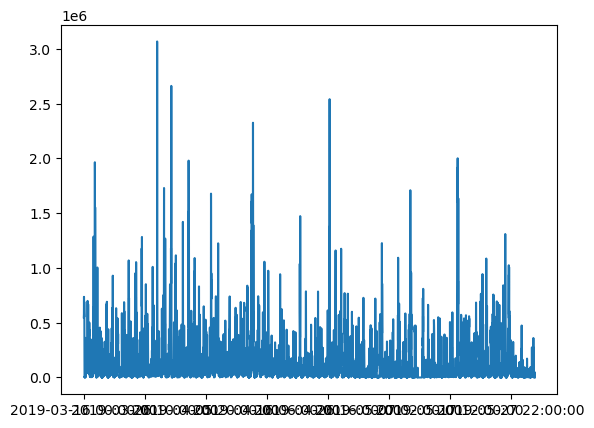

In [62]:
FOLDER_PATH = '../../../../data/rrochas/prediction_validation' 
app : 'Instagram'
transfer_mode = 'DL'
stadium = 'Lou_rugby'
folder_path_app = f"{FOLDER_PATH}/POIs/stadium/{app}"

print(f"Tackle {app} {transfer_mode} at {stadium}")
serie = pd.read_csv(f"{folder_path_app}/df_{stadium}_{transfer_mode}.csv",index_col = 0)
serie = serie.sum(axis=1)